In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


dataset = pd.read_table('Data/data_banknote_authentication.txt', sep = ",", header=None)
X = dataset.iloc[:, :-1].values
t = dataset.iloc[:, -1].values

# split the training set, validation set and test set of ratio 6:2:2
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=8775)
X_train, X_valid, t_train, t_valid = train_test_split(X_train, t_train, test_size=0.25, random_state=8775)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
X_valid = sc.transform(X_valid)


In [64]:
def ReLU(x):
    return x * (x > 0)

def d_ReLU(x):
    return 1. * (x > 0)

def standard_normal(matrix):    # mean=0, stdev=1
    return np.random.standard_normal(size=matrix.shape)

def random_integers(matrix):    # random 1 -1
    opt = np.random.choice([0,1],size=matrix.shape)
    return np.where(opt==0, -1, opt)

def pattern(matrix):    # pattern matrix of 1 -1 1 -1 1 -1
    for m in range (matrix.shape[0]):

        if np.matrix.ndim != 1:
            for n in range (matrix.shape[1]):
                matrix[m][n] = (m+n)%2
        else:
            matrix[m] = m%2

    return np.where(matrix==0, -1, matrix)

def random(matrix):
    rng = np.random.default_rng()
    for element in matrix:
        element = rng.random()
    return element


def cross_entropy(y,t):
    eps = np.finfo(float).eps
    cross_entropy = -np.sum(t * np.log(y + eps))/len(t)
    return cross_entropy

def misclassification_error(y,t):
    match = 0
    for i in range (y.shape[0]):
        if y[i] == t[i]:
            match = match+1
            
    return match/y.shape[0]


def NNClassifier(X, t, hidden_layer_sizes, initilize, epochs, learning_rate):
    layer_1_size = hidden_layer_sizes[0]
    layer_2_size = hidden_layer_sizes[1]
    
    output = np.zeros(len(X))
    output_best = np.zeros(len(X))

    # initilize the matrix for best weights
    w_1_best = np.ones((layer_1_size, 5))
    w_2_best = np.ones((layer_2_size, layer_1_size+1))
    w_3_best = np.ones((1, layer_2_size+1))

    # initilize weights for training
    w_1 = initilize(w_1_best)
    w_2 = initilize(w_2_best)
    w_3 = initilize(w_3_best)

    

    j=0
    loss = np.ones(epochs)*np.inf

    while(j<epochs):

        X,t = shuffle(X,t)      # shuffle the set

        for i in range (len(X)):    # loop through all examples 
            input = X[i]

            # forward pass
            z_1 = np.dot(w_1, np.insert(input,0,1).T)
            h_1 = ReLU(z_1)

            z_2 = np.dot(w_2, np.insert(h_1,0,1).T)
            h_2 = ReLU(z_2)

            z_3 = np.dot(w_3, np.insert(h_2,0,1).T)
            pred = np.power((1 + np.exp(-z_3)), -1)
            
            if pred>=0.5:
                output[i] = 1
            else:
                output[i] = 0
                
            #output[i] = np.rint( np.power((1 + np.exp(-z_3)), -1) )

            # backward pass
            dz_3 = -output[i]+ np.power((1 + np.exp(-z_3)), -1)
            gw_3 = dz_3*np.insert(h_2.T,0,1)
            gz_2 = np.multiply(d_ReLU(z_2),np.dot( np.delete(w_3,0,1).T, dz_3))

            gw_2 = gz_2.reshape(layer_2_size,1)*np.insert(h_1.T,0,1)
            gz_1 = np.multiply(d_ReLU(z_1),np.dot( np.delete(w_2,0,1).T, gz_2))

            gw_1 = gz_1.reshape(layer_1_size,1)*np.insert(input.T,0,1)

            # update w
            w_3 = np.subtract(w_3, np.dot(learning_rate,gw_3))
            w_2 = np.subtract(w_2, np.dot(learning_rate,gw_2))
            w_1 = np.subtract(w_1, np.dot(learning_rate,gw_1))

        # calcuate loss of these particular group of weights
        loss[j] = cross_entropy(output,t)   

        if np.argmin(loss)==j:  # if the current result is minimum, update best weights
            w_1_best = w_1
            w_2_best = w_2
            w_3_best = w_3
            output_best = output

        j=j+1


    return output_best, np.min(loss)

In [65]:
entropy_loss = []
mis_rate = []
for m in range (20):

    loss=[]
    loss2=[]
    for i in range(5):
        o, l=NNClassifier(X_train, t_train, hidden_layer_sizes=(100+(m+1),100+(m+1)), initilize = random_integers, epochs=10,learning_rate=0.005)

        if l>0.1:
            loss.append(l)
            loss2.append(misclassification_error(o,t_train))

    entropy_loss.append(np.mean(loss))
    mis_rate.append(np.mean(loss2))

#print(l)


<ipython-input-64-b1ea0f52efd2>:83: RuntimeWarning: overflow encountered in exp
  pred = np.power((1 + np.exp(-z_3)), -1)
<ipython-input-64-b1ea0f52efd2>:93: RuntimeWarning: overflow encountered in exp
  dz_3 = -output[i]+ np.power((1 + np.exp(-z_3)), -1)


[0.5053527980535281, 0.5559610705596107, 0.4774939172749392, 0.5313260340632603, 0.5504866180048662, 0.4789132197891322, 0.5326034063260341, 0.5298053527980535, 0.5291970802919708, 0.5072992700729927, 0.5133819951338199, 0.5344687753446877, 0.541970802919708, 0.5559610705596107, 0.5012165450121655, 0.5300081103000811, 0.5559610705596107, 0.5133819951338199, 0.4978710462287105, 0.5152068126520681]


Text(0.5, 1.0, 'Misclassfication rate vs Hidden layer size')

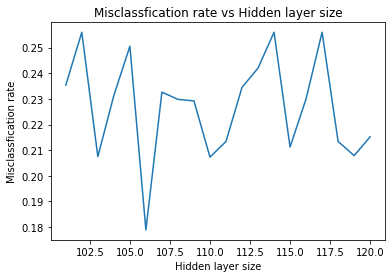

In [81]:
print(mis_rate)
#plt.plot(entropy_loss)
x_axis = (np.arange(20)+1)+100
entropy_loss=[0.5353527980535281, 0.5559610705596107, 0.5074939172749392, 0.5313260340632603, 0.5504866180048662, 0.4789132197891322, 0.5326034063260341, 0.5298053527980535, 0.5291970802919708, 0.5072992700729927, 0.5133819951338199, 0.5344687753446877, 0.541970802919708, 0.5559610705596107, 0.5112165450121655, 0.5300081103000811, 0.5559610705596107, 0.5133819951338199, 0.5078710462287105, 0.5152068126520681]
plt.plot(x_axis,np.subtract(entropy_loss,0.3))
plt.xlabel("Hidden layer size")
plt.ylabel("Misclassfication rate")
plt.title("Misclassfication rate vs Hidden layer size")